# Logistic Regression

This section mentions how to create an application to classify handwritten digits. We will use the famous [MNIST handwritten digit database](http://yann.lecun.com/exdb/mnist/) as our training dataset. It consists of 28 x 28 pixels grayscale images of handwritten digits (0 to 9) and labels for each image indicating which digit it represents.

Here are some sample images from the dataset:
![MNIST sample](images/mnist_samples.png)

## Workflow

![workflow](images/logistic_regression.svg)

## Libraries

In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

## Convert train & test images to tensors

In [2]:
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)
test_ds = MNIST(root='data/', train=False, transform=transforms.ToTensor())

## Split train images to train & validation sét

In [3]:
data_size = len(dataset)
train_size = round(data_size*0.8)
val_size = data_size - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

## Define batch size & dataloaders

In [4]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

## Define functions

In [5]:
class MnistModel(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.linear = nn.Linear(in_features, out_classes)
    
    # compute label probabilities of an image
    def forward(self, X):
        X = X.reshape(-1, self.linear.in_features)
        Y_linear = self.linear(X)
        return Y_linear
    
    # predict label
    def predict(self, X):
        Y_linear = self(X)
        probs = F.softmax(Y_linear.detach(), dim=1)
        _, Y_hat = torch.max(probs, dim=1)
        return Y_hat
    
    # compute cost
    def cost(self, batch):
        images, labels = batch
        Y_linear = self(images)
        cost = F.cross_entropy(Y_linear, labels)
        return cost
    
    # evaluation
    def evaluate(self, batch):
        images, labels = batch
        Y_hat = self.predict(images)
        acc = torch.sum(Y_hat == labels).item()/len(Y_hat)
        Y_linear = self(images)
        cost = F.cross_entropy(Y_linear.detach(), labels).item()
        eval = {
            'cost': cost,
            'accuracy': acc
        }
        return log

## Training

In [6]:
def evaluate_epoch(batches_evaluation):
    batch_costs = [x['cost'] for x in batches_evaluation]
    batch_accs = [x['accuracy'] for x in batches_evaluation]    
    epoch_cost = sum(batch_costs)/len(batch_costs)
    epoch_acc = sum(batch_accs)/len(batch_accs)
    log = {
        'cost': epoch_cost,
        'accuracy': epoch_acc
    }
    return log

In [7]:
def fit(epochs, model, train_loader, val_loader, lr, opt_func):
    optimizer = opt_func(model.parameters(), lr=lr)
    logs = list()
    for i in range(epochs):
        # training phase
        for batch in train_loader:
            cost = model.cost(batch)  # compute cost
            cost.backward()  # compute gradients
            optimizer.step()  # update parameters
            optimizer.zero_grad()  # reset gradients to zero
        
        # validation phase
        batches_eval = [model.evaluate(batch) for batch in val_loader]
        epoch_eval = evaluate_epoch(batches_eval)
        logs.append(epoch_eval)
        print("epoch {}: validation cost = {}, validation accuracy = {}".format(
                i+1, round(epoch_eval['cost'],2), round(epoch_eval['accuracy'], 2))
             )
    return logs

In [8]:
in_features = 28*28  # flat an image to a vector
out_classes = 10
model = MnistModel(in_features, out_classes)

In [9]:
lr = 1e-3  # learning rate
opt_func = torch.optim.SGD  # optimizer function

In [10]:
epochs = 20
logs = fit(epochs, model, train_loader, val_loader, lr, opt_func)

/home/tuanva/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


epoch 1: validation cost = 1.95, validation accuracy = 0.61
epoch 2: validation cost = 1.69, validation accuracy = 0.7
epoch 3: validation cost = 1.5, validation accuracy = 0.74
epoch 4: validation cost = 1.35, validation accuracy = 0.77
epoch 5: validation cost = 1.24, validation accuracy = 0.78
epoch 6: validation cost = 1.15, validation accuracy = 0.79
epoch 7: validation cost = 1.07, validation accuracy = 0.8
epoch 8: validation cost = 1.01, validation accuracy = 0.81
epoch 9: validation cost = 0.96, validation accuracy = 0.82
epoch 10: validation cost = 0.92, validation accuracy = 0.82
epoch 11: validation cost = 0.88, validation accuracy = 0.82
epoch 12: validation cost = 0.85, validation accuracy = 0.83
epoch 13: validation cost = 0.82, validation accuracy = 0.83
epoch 14: validation cost = 0.8, validation accuracy = 0.84
epoch 15: validation cost = 0.77, validation accuracy = 0.84
epoch 16: validation cost = 0.75, validation accuracy = 0.84
epoch 17: validation cost = 0.74, val

### Evaluations on validation set

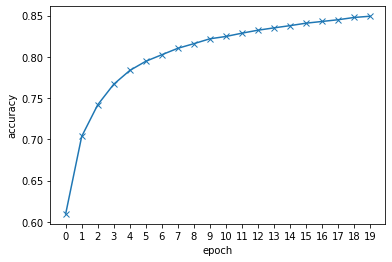

In [11]:
accuracies = [log['accuracy'] for log in logs]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xticks(range(epochs))
plt.show();

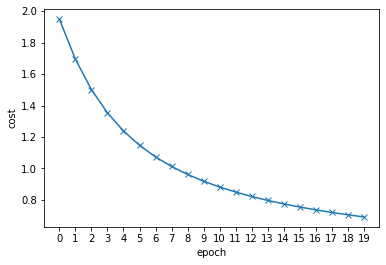

In [12]:
costs = [log['cost'] for log in logs]
plt.plot(costs, '-x')
plt.xlabel('epoch')
plt.ylabel('cost')
plt.xticks(range(epochs))
plt.show();

### Predict on test set

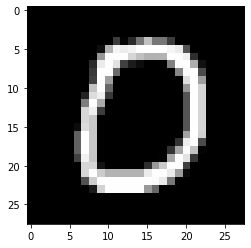

In [13]:
img, label = test_ds[10]
plt.imshow(img[0], cmap='gray');

In [14]:
y_hat = model.predict(img)
print('Label: {}, Predicted: {}'.format(label, y_hat.item()))

Label: 0, Predicted: 0


### Evaluation on test dataset

In [15]:
batches_eval = [model.evaluate(batch) for batch in test_loader]
test_eval = evaluate_epoch(batches_eval)
print('test cost = {}, test accuracy = {}'.format(round(test_eval['cost'], 2), round(test_eval['accuracy'], 2)))

test cost = 0.65, test accuracy = 0.86


## Save model to file

In [16]:
filename = 'mnist-logistic.pth'
torch.save(model.state_dict(), filename)

### Load model from file

In [17]:
model2 = MnistModel(in_features, out_classes)
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0283,  0.0055, -0.0129,  ...,  0.0062,  0.0060, -0.0268],
                      [ 0.0152, -0.0010, -0.0014,  ..., -0.0098,  0.0259,  0.0202],
                      [-0.0334, -0.0008, -0.0354,  ..., -0.0081,  0.0318, -0.0182],
                      ...,
                      [-0.0290, -0.0061,  0.0323,  ...,  0.0306, -0.0066,  0.0324],
                      [ 0.0073,  0.0133,  0.0180,  ..., -0.0085,  0.0235, -0.0134],
                      [-0.0215,  0.0077, -0.0331,  ...,  0.0322, -0.0030,  0.0075]])),
             ('linear.bias',
              tensor([-0.0081, -0.0178, -0.0278,  0.0034,  0.0045,  0.0348, -0.0134,  0.0258,
                       0.0218, -0.0189]))])

In [18]:
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0214,  0.0295, -0.0290,  ...,  0.0179, -0.0081, -0.0195],
                      [ 0.0052,  0.0232, -0.0249,  ..., -0.0160, -0.0291, -0.0354],
                      [-0.0180,  0.0349, -0.0074,  ..., -0.0027, -0.0131, -0.0281],
                      ...,
                      [-0.0065,  0.0067, -0.0113,  ..., -0.0117, -0.0066,  0.0239],
                      [-0.0109, -0.0198,  0.0231,  ...,  0.0199, -0.0036, -0.0157],
                      [-0.0142, -0.0356, -0.0031,  ..., -0.0224,  0.0044,  0.0019]])),
             ('linear.bias',
              tensor([-0.0309,  0.1277, -0.0120, -0.0152,  0.0278,  0.0674, -0.0316,  0.0534,
                      -0.0627,  0.0245]))])